<a href="https://colab.research.google.com/github/VodkaSin/Smart_Coach_Project/blob/main/Smart_Coach_Update1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

## Install packages

In [1]:
!pip install -q tensorflow==2.6.0 tensorflow-gpu==2.6.0
!pip install -q gTTS
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 458.3 MB 12 kB/s 


## Import libraries

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow_docs.vis import embed 

import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection 
import matplotlib.patches as patches
import matplotlib.ticker as mtick

# Some modules to display an animation using imageio.
import imageio 
import PIL
import io
import math
import time
from datetime import datetime
from IPython.display import display, Javascript, Image, HTML, Audio # When are all these used?
from gtts import gTTS
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode

# Data access (privacy)
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
import re

## Visualization helper functions

1. Streaming APIs
2. Recording and display videos
3. Smart cropping
4. Frame rendering

### Streaming

In [3]:
# JavaScript to create video stream from webcam
def start_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 192,192);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span></span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      video.style.cssText = "-moz-transform: scale(-1, 1); \
-webkit-transform: scale(-1, 1); -o-transform: scale(-1, 1); \
transform: scale(-1, 1); filter: FlipH;";
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 192; //video.videoWidth;
      captureCanvas.height = 192; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [4]:
# Capture frame in bytes from streaming
def take_frame(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [5]:
def js_to_image(js_reply):
  """ Used in main function to convert image types
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BRG image (mirror flipped)
  """
  # decode base64 image
  image_bytes = b64decode(js_reply['img'].split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  img = cv2.flip(img,1)

  return img

In [6]:
def bbox_to_bytes(bbox_array):
  """ Used in the main function to convert numpy overlay onto the frame
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

### Recording and displaying

In [7]:
def record_video(video_path):
  """ Called in the main function as an option to record the exercise video for later reference
  Params:
          video_path: a path name for storing the video
  """
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
    
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(video_path,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{video_path}")
  except Exception as err:
    print(str(err))

In [8]:
def show_video(video_path, video_width = 600):
  """ Called when the user wants to review their workout recording and pose estimation
  Params:
          video_path: local
          video_width: default = 600
  Returns:
          Display the video in cell
  """
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

### Cropping algorithm

In [9]:
# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region, provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

In [10]:
def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

In [11]:
def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

In [12]:
def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

In [13]:
def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

In [14]:
def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

### Rendering

In [15]:
def draw_keypoints(frame, keypoints, array, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    points = []
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            array = cv2.circle(array, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, array, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            array = cv2.line(array, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)

In [16]:
def draw_text(array, org, text, color):
  array = cv2.putText(array, text, org, cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA )

## Model algorithm

1. Libraries of definitons (joints and angles), 
2. Model loading
3. Angle calculation algorithm
4. Squat counter logic



### Definitions

In [17]:
# Dictionary that maps from joint names to keypoint indices.

EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}


# Note that the image is flipped, here the keys refer to the user's pov
THREE_JOINT_INDEX = {
    'right_shoulder (H)': (11,5,7),
    'right_shoulder (S)': (7,5,6),
    'left_shoulder (H)': (12,6,8),
    'left_shoulder (S)': (8,6,5),
    'right_elbow':(5,7,9),
    'left_elbow':(6,8,10),
    'right_torso':(5,11,13),
    'left_torso':(6,12,14),
    'right_knee':(11,13,15),
    'left_knee':(12,14,16),
    'right_torso turn':(6,5,11),
    'left_torso_turn':(5,6,12)
}
FOUR_JOINT_INDEX ={
    'shoulders_hips':(5,6,11,12),
    'btw_legs':(11,13,12,14)
}

### Model loading

In [18]:
# Grab from TF hub and initialize interpreter
!wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3?lite-format=tflite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

In [19]:
# Interpreter
def movenet(frame):
  """ Runs detection on an input frame
  Params:
          frame: 192x192 opencv BRG
  Returns:
          keypoints_with_scores: [index, location, confidence]
  """  
  # Reshape iamge to 192x192x3
  img = tf.image.resize_with_pad(np.expand_dims(frame, axis=0), 192,192)
  input_image = tf.cast(img, dtype=tf.float32) # Specify data type

  # Setup input and output 
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Make predictions 
  interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
  interpreter.invoke()
  keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
  return keypoints_with_scores

### Squat counter

In [20]:
def find_side_squat(keypoints_with_scores, threshold=0.2):
  '''1. Extract the joints needed: 5,6 (shoulders), 11,12 (hips), 13,14 (knees), 15,16 (ankles)
     2. Compare the confidence for both sides: use only the side with higher confidence and if any 
        angle in the confidence side < threshold, output key 'Bad detection'= False
     3. Ouput side [keypoints_with_scores(shoulder, hip, knee, ankle)]
     Note: here left and right is the opposite of the user's left and right due to the mirroring effect.'''
  left = [keypoints_with_scores[0][0][5],keypoints_with_scores[0][0][11],keypoints_with_scores[0][0][13],keypoints_with_scores[0][0][15]]
  right = [keypoints_with_scores[0][0][6],keypoints_with_scores[0][0][12],keypoints_with_scores[0][0][14],keypoints_with_scores[0][0][16]]
  left_confidence = [left[i][2] for i in range (4)]
  right_confidence = [right[i][2] for i in range (4)]
  if sum(left_confidence) > sum(right_confidence):
    side = np.asarray(left)
    confidence = left_confidence
  else:
    side = np.asarray(right)
    confidence = right_confidence
  for i in range(3):
    if confidence[i]<threshold:
      return None, False
  return np.delete(side,2,1), True

In [21]:
def squat_angles(side):
  an1 = getAngle(side[0],side[1],side[2])
  an2 = getAngle(side[1],side[2],side[3])
  torso = an1 if an1 < 180 else 360-an1
  knee = an2 if an2 < 180 else 360-an2
  return torso, knee

In [22]:
def squat_count(torso, knee):
  '''Default: 
    1. knee flexion below 100 is considered ok, the user should aim for squatting
           down deeper, below 60 is excellent mobility.
    2. hip flexion is counted when angle smaller than 90 but should be larger than 70
    3. getting up, the knee should be 180 in ideal case, 170 is considered OK, same for hip flexion
    
    Parameters:
    angle: [hip flexion left, hip flexion right, knee flexion left, knee flexion right] list of degree
    stage = string, indicator for the counter, if 'down' counter+1'''
  if torso < 125:
    stage = 'down'
    score = 1
    if knee < 95 and torso > 45:
      score = 2
  else:
    if torso <160:
      stage = 'down'
    else: 
      stage = 'up'
    score = -1
  return stage, score

### Angle calculation

In [23]:
def getAngle(a, b, c):
    ang = abs(math.degrees(math.atan2(b[1]-c[1], b[0]-c[0]) - math.atan2(b[1]-a[1], b[0]-a[0])))
    return ang

In [24]:
def getAngle2(a,b,c,d):
  # For 4 point inputs (two crossing lines)
  dx = c[1]-a[1]
  dy = c[0]-a[0]
  return getAngle(b,a,(d[0]-dx,d[1]-dy))

In [25]:
def find_angle_3(keypoints_with_scores, threshold=0.1):
  angles = {}
  for keys, indexs in THREE_JOINT_INDEX.items():
    a = []
    flag = True
    for i in indexs:
      if keypoints_with_scores[0][0][i][2]<threshold:
        flag = False
        break
      a.append((keypoints_with_scores[0][0][i][1],keypoints_with_scores[0][0][i][0]))
    if flag:
      angles[keys] = getAngle(a[0],a[1],a[2])
  return angles   

In [26]:
def find_angle_4(keypoints_with_scores, threshold=0.1):
  angles = {}
  for keys, indexs in FOUR_JOINT_INDEX.items():
    a = []
    flag = True
    for i in indexs:
      if keypoints_with_scores[0][0][i][2]<threshold:
        flag = False
        break
      a.append((keypoints_with_scores[0][0][i][1],keypoints_with_scores[0][0][i][0]))
    if flag:
      angles[keys] = getAngle2(a[0],a[1],a[2],a[3])
  return angles

## Main inference function

In [27]:
def app():
  start_stream()
  label_html = 'Smart Coach'  #label
  img_data = ''
  max_score = 0
  total_score = 0
  total_good = 0
  total_excellent = 0
  total_bad = 0
  combo_bad = 0
  combo_excellent = 0
  store = []
  times = np.empty(1)
  forms = []
  bad_torsos = []
  bad_knees = []
  low_torso = 0

  goal = input('Enter your target score: ')

  '''image_height, image_width = 192, 192
  crop_region = init_crop_region(image_height, image_width)'''
  while True:
      js_reply = take_frame(label_html, img_data)
      if not js_reply:
        print('Streaming has been interupted')
        break
      start = time.time()
      # Process Javascript Object (frame) to OpenCV BRG
      frame = js_to_image(js_reply)
      # Initialize render array
      img_array= np.zeros([192,192,4], dtype=np.uint8)
      # Run the interpreter on the BRG image
      keypoints_with_scores = movenet(frame)
      side, flag = find_side_squat(keypoints_with_scores)
      if flag == False:
        draw_text(img_array,(10,100),'Please adjust your position', (255,0,0))
      else:
        torso, knee = squat_angles(side)
        if torso<45:
          low_torso += 1
          if low_torso == 1:
            hunch_form = frame.copy()
            draw_text(hunch_form,(10,35),'Hunched back: '+str(int(low_torso)), (255,255,0))
            forms.append(hunch_form)
          draw_text(img_array,(10,100),'Please straighten your back', (255,255,0))
        stage, score = squat_count(torso, knee)
        store.append([torso,knee,stage,score])
        #draw_text(img_array,(100,120),'torso ' + str(torso), (255,0,0))
        #draw_text(img_array,(100,140),'knee ' + str(knee), (255,0,0))
        # Only count the highest score in one rep and avoid double counting
        if stage =='down':
          if score == 2 and score > max_score: 
            max_score = score
            total_score += max_score
            total_excellent += 1
            combo_bad = 0
            combo_excellent += 1
            draw_text(img_array,(50,50),'Excellent x'+str(combo_excellent), (255,0,127))
            if total_exellent == 1:
              excellent_form = frame.copy()
              draw_text(excellent_form,(10,35),'Excellent! ', (255,0,127))
              forms.append(excellent_form)
            if combo_excellent > 3:
              total_score += 1
          if score == 1 and max_score < 2:
            max_score = score
          if score == -1 and max_score == 0:
            max_score = score
            bad_form = frame.copy()
            bad_keypoints = keypoints_with_scores
            bad_torso = torso
            bad_knee = knee
        if stage == 'up':
          if max_score == 1:
            total_score += max_score
            total_good += 1
            combo_bad = 0
            combo_excellent = 0
            draw_text(img_array,(50,50),'Good!', (102,178,255))
            if total_good == 1:
              good_form = frame.copy()
              draw_text(good_form,(10,35),'Can squat down more', (255,0,127))
              forms.append(good_form)
          if max_score == -1:
            total_bad += 1
            combo_bad +=1
            combo_excellent = 0
            if total_bad < 4:
              draw_text(bad_form,(10,20),'Miss x '+str(total_bad), (255,255,0))
              draw_keypoints(frame, bad_keypoints, bad_form, 0.2)
              draw_connections(frame, bad_keypoints, EDGES, bad_form, 0.2)
              draw_text(bad_form,(10,35),'Torso: '+str(int(bad_torso)), (255,255,0))
              draw_text(bad_form,(10,50),'Knee: '+str(int(bad_knee)), (255,255,0))
            draw_text(img_array,(50,50),'Miss x '+str(combo_bad), (0,0,255))
            bad_torsos.append(int(bad_torso))
            bad_knees.append(int(bad_knee))
            bad_forms.append(bad_form)
          score = 0
          max_score = 0
      if combo_bad > 3:
        break
      if total_score == goal:
        draw_text(img_array,(10,100),'Goal achieved! Take a break!', (0,255,0))
        break
      # Rendering the keypoints and edges: add to img_array and convert to JS, uncomment if you want to see the pose estimation
      draw_text(img_array,(10,20),'Total score: '+str(total_score), (102,255,102))
      draw_text(img_array,(10,35),'Total count: '+str(total_good+total_excellent), (255,255,0))
      draw_text(img_array,(10,185),'Total miss: '+str(total_bad), (0,0,255))
      img_array[:,:,3] = (img_array.max(axis = 2)>0).astype(int)*255
      img_data = bbox_to_bytes(img_array)
      stop = time.time()
      duration = stop-start
      times = np.append(times, duration)
      
  if total_bad>5 or combo_bad>3:
    tts = gTTS('Game over! See feedback below!')
  else:
    tts = gTTS('Workout completed, congratulations! See feedback below!')

  tts.save('1.wav')
  sound_file = '1.wav'
  Audio(sound_file, autoplay=True)

  print('---------WORKOUT SUMMARY---------'+'\n')
  print('Total score     |         ',total_score)
  print('Total reps      |         ', total_good+total_excellent)
  print('Excellent reps  |         ',total_excellent)
  print('Good reps       |         ',total_good)
  print('Missed reps     |         ', total_bad,'\n')

  if total_bad>2:
    # Show screenshots of the person's bad squats x3
    torsos = round(sum(bad_torsos)/len(bad_torsos),2)
    knees = round(sum(bad_knees)/len(bad_knees),2)
    print('-----------FEEDBACK-----------'+'\n')
    print('1. In the missed reps, your average hip flexion is',str(torsos),'degrees, aim for 70 to 95 degrees')
    if knees > 95:
      print('2. Your knees seem too stiff, aim for 60 to 95 degrees')
    if low_torso != 0: 
      print('3. We also noticed that you might have been hunching your back during the excercise for',str(low_torso),'times, try to avoid that!')
    print('\n'+'Don\'t worry, just try again, you will get better!')
    
  if input('\n'+'Check your form? (y/n): ')=='y':
      for photo in bad_forms:
          cv2_imshow(photo)      
  else:
    print('Well done!')

# Smart Coach

1. Streaming of mirrored web cam input with pose estimation rendered on frame
2. Print output for immediate reading
3. Text output for record.

In [28]:
start_time = !date
start_time = int(start_time[0][11:-9].replace(':',''))
start = time.time()
print(start_time)
app()
end = time.time()
duration = end-start

94726


<IPython.core.display.Javascript object>

Enter your target score: 200
Streaming has been interupted
---------WORKOUT SUMMARY---------

Total score     |          0
Total reps      |          0
Excellent reps  |          0
Good reps       |          0
Missed reps     |          0 


Check your form? (y/n): n
Well done!


In [ ]:
start = time.time()


In [ ]:
end = time.time()
print(start, end)
duration = end-start
print(duration)

# Data collection

1. Testing of frame rate

Collected points: 185
Average loop time(s): 0.03977726472390664
Standard deviation(s): 0.0031075310674482546


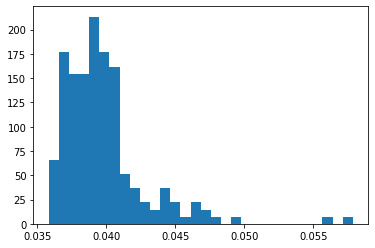

In [ ]:
points = np.size(times)
print('Collected points:', points)
sorted = np.sort(times)
print('Average loop time(s):', np.mean(sorted))
print('Standard deviation(s):', np.std(sorted))
plt.hist(sorted, density=True, bins=30)
plt.show()

In [ ]:
print(store)

[]


In [ ]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

[['time', 'heartrate', 'oxygenlevel'], ['11/4/2021 23:44:41', '66', '94'], ['11/4/2021 23:44:47', '68', '95'], ['11/4/2021 23:44:52', '68', '94'], ['11/4/2021 23:44:56', '64', '96'], ['11/4/2021 23:45:01', '65', '97'], ['11/4/2021 23:45:06', '67', '96'], ['11/4/2021 23:45:10', '66', '96'], ['11/4/2021 23:45:15', '65', '96'], ['11/4/2021 23:45:20', '65', '96'], ['11/4/2021 23:45:24', '64', '96'], ['11/4/2021 23:45:29', '67', '95'], ['11/5/2021 0:11:21', '56', '98'], ['11/5/2021 0:11:25', '57', '97'], ['11/5/2021 0:11:30', '56', '97'], ['11/5/2021 0:11:35', '58', '97'], ['11/5/2021 0:11:39', '61', '97'], ['11/5/2021 0:11:44', '61', '96'], ['11/5/2021 0:11:50', '61', '0'], ['11/5/2021 0:16:37', '57', '98'], ['11/5/2021 0:16:42', '56', '98'], ['11/5/2021 0:16:47', '57', '98'], ['11/5/2021 0:17:03', '95', '97'], ['11/5/2021 0:17:08', '95', '98'], ['11/5/2021 0:17:22', '56', '98'], ['11/5/2021 0:17:27', '63', '98'], ['11/5/2021 0:25:48', '66', '100'], ['11/5/2021 0:26:05', '76', '95'], ['11/

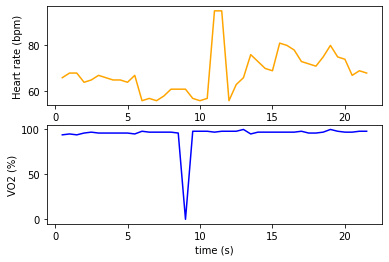

In [ ]:
worksheet = gc.open('Data (Bryan)').sheet1
spr=0.5
rows = worksheet.get_all_values()
print(rows)
length = len(rows)
datetimes = [rows[i][0] for i in range (1,length)]
start_index = 1
for t in range(length-1):
  sheet_time = int(datetimes[t][-8:].replace(':',''))
  if sheet_time == start_time:
    start_index = t
    break
  if sheet_time > (start_time - 2) and sheet_time < (start_time + 2):
    start_index = t
end_index = start_index + int(duration/spr)
heart_rates = [int(rows[i][1]) for i in range(start_index,end_index)]
blood_ox = [int(rows[i][2]) for i in range(start_index,end_index)]
time = [i*spr for i in range(start_index,end_index)]
plt.figure() 
plt.subplot(2, 1, 1) # (rows, columns, panel number)
plt.plot(time,heart_rates, color='orange')
plt.ylabel('Heart rate (bpm)')
plt.subplot(2, 1, 2)
plt.plot(time, blood_ox, color='blue')
plt.ylabel('VO2 (%)')
plt.xlabel('time (s)')

plt.show()

Enter your maximum heart rate (or 'n' if unknown): 200
200


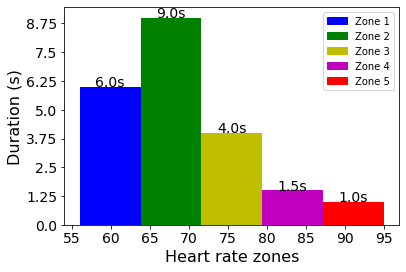

In [ ]:

MHR = input('Enter your maximum heart rate (or ''\'n''\' if unknown): ')
if MHR == 'n':
  age = int(input('Enter your age: '))
  MHR = 220-age
else:
  MHR=int(MHR)
print(MHR)
bins = [0.3*MHR,0.6*MHR,0.7*MHR,0.8*MHR,0.9*MHR,1*MHR]
labels = ['Zone 1','Zone 2','Zone 3','Zone 4','Zone 5']
colors = ['b','g','y','m','r']
handles = [Rectangle((0,0),1,1,color=c) for c in colors]
plt.figure()
N, bins, patches = plt.hist(heart_rates, bins=5)
count, _ = np.histogram(heart_rates, bins)
for i in range (5):
  color = colors[i]
  patches[i].set_facecolor(color)
  plt.text(bins[i]+2, N[i], str(count[i]*spr)+'s', fontsize=14)

plt.legend(handles, labels)
plt.xlabel("Heart rate zones",fontsize=16)  
plt.ylabel("Duration (s)",fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
def scale_time(x,*args):
  x = float(x)*spr
  return x
ax = plt.gca()       
ax.yaxis.set_major_formatter(mtick.FuncFormatter(scale_time))
plt.show()


In [ ]:
from datetime import datetime
import re
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Singapore /etc/localtime
stre = !date
current_time = stre[0][11:-9]
sheettime = datetimes[0][-8:]
print(current_time,sheettime)
current_time = current_time.replace(':','')
numbers = [int(s) for s in re.findall(r'\b\d+\b', current_time)]
print(numbers)
print(current_time>sheettime)


12:54:22 23:44:41
[125422]
False


In [ ]:
stre2 = !date
print(stre2[0][11:-9])

12:40:13
